<h1 style="text-align:center; font-size:39px;">Proyecto de web scraping</h1>


<h1 style="text-align:center; font-size:19px;">Programación para la ciencia de datos</h1>


<h1 style="text-align:center; font-size:19px;">Nicolás Bohórquez Tejada</h1>


<h1 style="text-align:center; font-size:19px;">Politécnico Grancolombiano</h1>


# Objetivo principal

## El objetivo principal de este proyecto es poder realizar un web scraping exitoso a los libros de diferentes generos literarios y poder realizar un analisis de estos

#### Cargamos algunas de las librerias que necesitaremos

In [4]:
import re
import psycopg2
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


#### 1. Código para poder extraer las diferentes variables que se encuentran en el diccionario mediante su path

In [2]:
import requests
from bs4 import BeautifulSoup

class mycrawler:
    def __init__(self, nombre, urlinicial):
        self.nombre = nombre
        self.urlactual = urlinicial
        self.diccdeinfo = {}

    def obtenerinfo(self):
        r = requests.get(self.urlactual)
        html_content = r.text
        soup = BeautifulSoup(html_content, "html.parser")

        titulo = soup.find("title").text
        precio = soup.find("p", class_="precioAntes")
        precio_actual = soup.find("p", class_="precioAhora")
        editorial = soup.find("div", {"id": "metadata-editorial"})
        ano = soup.find("div", {"id": "metadata-ano"})

        self.diccdeinfo = {
            "Título": titulo,
            "Precio sin descuento en COP": precio.text.strip(),
            "Precio con descuento en COP": precio_actual.text.strip(),
            "Editorial": editorial.find("a").text,
            "Año": ano.text.strip()
            }

       
    def actualizarurl(self, nueva_url):
        self.urlactual = nueva_url

class libro:
    def __init__(self, titulo, autor, isbn, precio_cop, editorial, ano, precio_sin_descuento=None):
        self.titulo = titulo
        self.autor = autor
        self.isbn = isbn
        self.precio_cop = precio_cop
        self.editorial = editorial
        self.ano = ano
        self.precio_sin_descuento = precio_sin_descuento
        
        
    def con_descuento(self):
        return self.precio_sin_descuento is not None

    def sin_descuento(self, descuento):
        if descuento > 0 and self.precio_cop > 0:
            self.sin_descuento = self.precio_cop / (1 - descuento)

### 2. En este chunk, establecemos la conexión con la base de datos y además procedemos con la inserción de los datos recolectados con el scraping a la base de datos, en el ciclo for determinamos los n libros que queremos recolectar, en este caso seleccione 10 porque son 10 enlaces de 10 generos literarios diferentes, por lo que serán 100 datos

In [6]:
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless') 
driver = webdriver.Chrome(options=chrome_options)

db_params = {
    'database': 'Web_scraping_busca_libre',
    'user': 'postgres',
    'password': 'Nico1029',
    'host': 'localhost',
    'port': '5432',
}

def obtener_libros_y_guardar_en_db(url):
    driver.get(url)

    idioma = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@name="fl" and @value="espanol"]'))
    )
    idioma.click()

    libros_info = WebDriverWait(driver, 10).until(
        EC.presence_of_all_elements_located((By.CLASS_NAME, 'imagen'))
    )

    for i in range(min(10, len(libros_info))):
        libro = libros_info[i].find_element(By.XPATH, '../..')

        titulo = libro.find_element(By.CLASS_NAME, 'nombre').text
        autor = libro.find_element(By.CLASS_NAME, 'autor').text
        editorial_y_ano = libro.find_element(By.CLASS_NAME, 'metas').text
        stock_text = libro.find_element(By.CLASS_NAME, 'stock').text
        descuento = libro.find_element(By.CLASS_NAME, 'descuento-v2').text
        precio_antes = libro.find_element(By.CLASS_NAME, 'precio-antes').text
        precio_ahora = libro.find_element(By.CLASS_NAME, 'precio-ahora').text

        imagen_url = libro.find_element(By.XPATH, './/img').get_attribute('data-src')

        editorial, ano, *otros = map(str.strip, editorial_y_ano.split(','))
        ano_parts = ano.split()
        ano = int(ano_parts[0]) if ano_parts[0].isdigit() else 0


        ano = int(ano)

        match = re.search(r'\d+', stock_text)
        stock = int(match.group()) if match else 0

        descuento = int(re.search(r'\d+', descuento.replace('%', '')).group()) if descuento else 0

        precio_antes = libro.find_element(By.CLASS_NAME, 'precio-antes').text
        precio_antes = precio_antes.replace('$', '').replace(',', '')

        precio_antes = float(precio_antes) if precio_antes else 0.0

        precio_ahora = libro.find_element(By.CLASS_NAME, 'precio-ahora').text
        precio_ahora = precio_ahora.replace('$', '').replace(',', '')

        precio_ahora = float(precio_ahora) if precio_ahora else 0.0

        guardar_en_db(titulo, autor, editorial, ano, stock, descuento, precio_antes, precio_ahora, imagen_url)

def guardar_en_db(titulo, autor, editorial, ano, stock, descuento, precio_antes, precio_ahora, imagen_url):
    try:
        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()

        cursor.execute(
            """
            INSERT INTO Libros 
            (titulo, autor, editorial, anio_publicacion, stock, descuento_porcentaje, precio_antes, precio_ahora, imagen_url)
            VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s);
            """,
            (titulo, autor, editorial, ano, stock, descuento, precio_antes, precio_ahora, imagen_url)
        )

        connection.commit()
        print(f"Registro insertado en la base de datos: {titulo}")

    except (Exception, psycopg2.Error) as error:
        print(f"Error al insertar en la base de datos: {error}")

    finally:
        if connection:
            cursor.close()
            connection.close()

obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/arte")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/filologia")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/ciencias-de-la-tierra-geografia-medioambiente-planificacion")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/economia-finanzas-empresa-y-gestion")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/computacion-y-tecnologia-de-la-informacion")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/deportes-y-actividades-de-ocio-al-aire-libre")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/derecho")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/estilos-de-vida-aficiones-y-ocio")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/ficcion-y-temas-afines")
obtener_libros_y_guardar_en_db("https://www.buscalibre.com.co/libros/infantiles-juveniles-y-didacticos")

driver.quit()


Registro insertado en la base de datos: Balada de pájaros cantores y serpientes
Registro insertado en la base de datos: El camino del artista
Registro insertado en la base de datos: Beyond the Story. Crónica de 10 Años de BTS
Registro insertado en la base de datos: El resplandor
Registro insertado en la base de datos: Carmilla
Registro insertado en la base de datos: La depresión (no) existe
Registro insertado en la base de datos: Persépolis
Registro insertado en la base de datos: Carrie
Registro insertado en la base de datos: Roba Como un Artista: Las 10 Cosas que Nadie te ha Dicho Acerca de ser Creativo
Registro insertado en la base de datos: El Arte de Mickey Mouse
Registro insertado en la base de datos: Este es el cordero de Dios
Registro insertado en la base de datos: El infinito en un junco
Registro insertado en la base de datos: Pensar Rápido Pensar Despacio
Registro insertado en la base de datos: La Bailarina de Auschwitz
Registro insertado en la base de datos: En esta noche, en

### 3. En este chunk organizamos y filtramos la base de datos de postgresql para filtrar por descuento, declaramos e innicializamos con un valor que querramos sea el % de descuento que queramos observar

In [7]:
import psycopg2

connection = psycopg2.connect(database='Web_scraping_busca_libre', user='postgres', password='Nico1029', host='localhost', port='5432')
cursor = connection.cursor()

umbral_descuento = 30

consulta_sql = "SELECT * FROM Libros WHERE descuento_porcentaje > %s;"
cursor.execute(consulta_sql, (umbral_descuento,))

resultados = cursor.fetchall()

for libro in resultados:
    print("Título:", libro[1])
    print("Autor:", libro[2])
    print("Descuento (%):", libro[6])
    print("Precio antes:", libro[7])
    print("Precio ahora:", libro[8])
    print("Imagen URL:", libro[9])
    print("=" * 50)

cursor.close()
connection.close()


Título: Balada de pájaros cantores y serpientes
Autor: Suzanne Collins
Descuento (%): 32
Precio antes: 65.00
Precio ahora: 44.20
Imagen URL: https://images.cdn2.buscalibre.com/fit-in/180x180/92/18/92182a2e5775d1ccee7ef9e9c219e8a8.jpg
Título: El camino del artista
Autor: Julia Cameron
Descuento (%): 32
Precio antes: 62.00
Precio ahora: 42.16
Imagen URL: https://images.cdn1.buscalibre.com/fit-in/180x180/45/69/45699dff81361c438df2c4c22ce8d708.jpg
Título: El resplandor
Autor: Stephen King
Descuento (%): 32
Precio antes: 49.00
Precio ahora: 33.32
Imagen URL: https://images.cdn2.buscalibre.com/fit-in/180x180/7c/58/7c5842eff164aa6d1b0f22f822261092.jpg
Título: La depresión (no) existe
Autor: Juan Carlos Rincón Escalante, Cecilia Ramos Valencia
Descuento (%): 32
Precio antes: 50.00
Precio ahora: 34.00
Imagen URL: https://images.cdn3.buscalibre.com/fit-in/180x180/b5/ff/b5ffc0592d3b772209b97ddf322b9c5e.jpg
Título: Persépolis
Autor: Marjane Satrapi
Descuento (%): 32
Precio antes: 75.00
Precio ahor

### 4. Mediante una interfaz, seleccionamos la carpeta donde vamos a guardar las imagenes de las portadas de los n libros seleccionados 

In [9]:
import os
import requests
from io import BytesIO
from PIL import Image
from tkinter import filedialog
import psycopg2  

db_params = {
    'database': 'Web_scraping_busca_libre',
    'user': 'postgres',
    'password': 'Nico1029',
    'host': 'localhost',
    'port': '5432',
}

directorio_destino = filedialog.askdirectory()

if not os.path.exists(directorio_destino):
    os.makedirs(directorio_destino)

query = "SELECT id, imagen_url FROM Libros;"
try:
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()

    cursor.execute(query)
    results = cursor.fetchall()

    for row in results:
        libro_id, imagen_url = row

        response = requests.get(imagen_url)
        img = Image.open(BytesIO(response.content))

        img = img.convert('RGB')

        image_path = os.path.join(directorio_destino, f"imagen_{libro_id}.jpg")
        img.save(image_path)

        print(f"Imagen descargada y guardada: {image_path}")

except (Exception, psycopg2.Error) as error:
    print(f"Error al obtener datos de la base de datos: {error}")

finally:
    if connection:
        cursor.close()
        connection.close()

Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_1.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_2.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_3.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_4.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_5.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_6.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_7.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_8.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_9.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_10.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_11.jpg
Imagen descargada y guardada: C:/Users/Nico/Downloads/100imagenes\imagen_12.jpg
Imagen descargada y guardada: C:/Users/Nico/Downl

In [9]:
!pip install colorthief


In [14]:
!pip install webcolors

### 5. En estos siguientes dos chunks de código, lo que se realiza es cargar el path de la carpeta de imagenes del ítem anterior y analizar las n imagenes para poder determinar cuales son los colores que más se repiten en las portadas de los libros más vendidos

In [10]:
import os
from PIL import Image
from colorthief import ColorThief

def obtener_colores_dominantes_en_carpeta(carpeta, numero_colores=3):
    colores_dominantes_globales = []

    archivos_en_carpeta = [f for f in os.listdir(carpeta) if os.path.isfile(os.path.join(carpeta, f))]

    for archivo in archivos_en_carpeta:
        imagen_path = os.path.join(carpeta, archivo)

        imagen = Image.open(imagen_path)

        color_thief = ColorThief(imagen_path)
        paleta = color_thief.get_palette(color_count=numero_colores)

        colores_dominantes_globales.extend(paleta)

    colores_dominantes_globales.sort(key=lambda color: sum(color), reverse=True)

    colores_dominantes_globales = colores_dominantes_globales[:numero_colores]

    return colores_dominantes_globales

carpeta_imagenes = "C:/Users/Nico/Documents/imagenesprueba"

colores_dominantes_globales = obtener_colores_dominantes_en_carpeta(carpeta_imagenes)

print(f"Colores dominantes globales: {colores_dominantes_globales}")


Colores dominantes globales: [(248, 244, 220), (248, 244, 220), (248, 244, 220)]


In [13]:
from PIL import Image

def crear_imagen_color(color, tamano=(100, 100)):
    imagen = Image.new("RGB", tamano, color)
    return imagen

carpeta_guardado = "C:/Users/Nico/Downloads/100imagenes"

for i, color in enumerate(colores_dominantes_globales):
    imagen_color = crear_imagen_color(color)
    ruta_imagen = os.path.join(carpeta_guardado, f"color_{i + 1}.png")
    imagen_color.save(ruta_imagen)
    print(f"Imagen del color {i + 1} guardada en: {ruta_imagen}")


Imagen del color 1 guardada en: C:/Users/Nico/Downloads/100imagenes\color_1.png
Imagen del color 2 guardada en: C:/Users/Nico/Downloads/100imagenes\color_2.png
Imagen del color 3 guardada en: C:/Users/Nico/Downloads/100imagenes\color_3.png


## Gráficas

### 6. Creamos una primera gráfica para el stock de los libros y sus respectivos autores

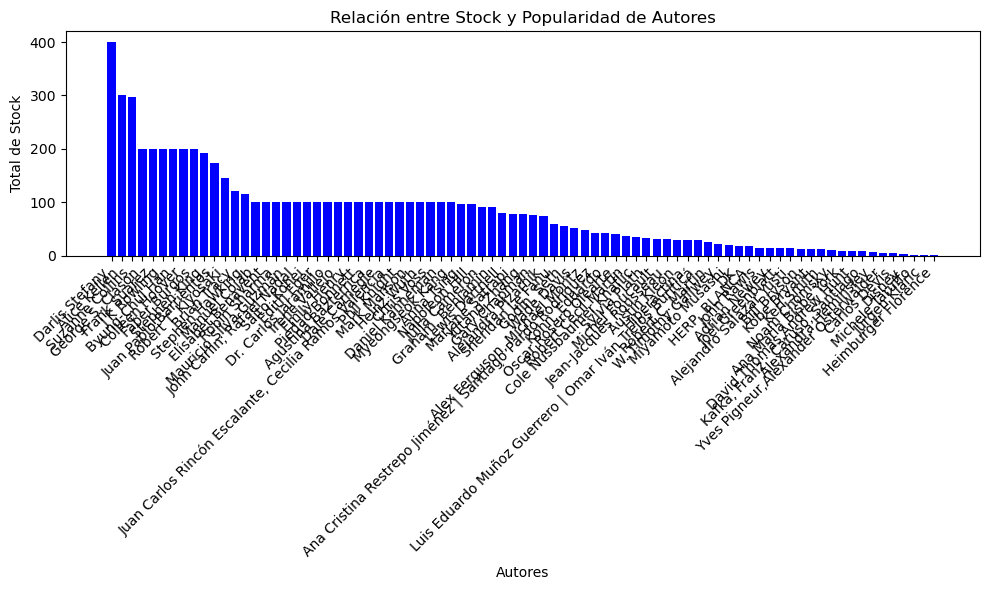

In [14]:
import psycopg2
import matplotlib.pyplot as plt

db_params = {
    'database': 'Web_scraping_busca_libre',
    'user': 'postgres',
    'password': 'Nico1029',
    'host': 'localhost',
    'port': '5432',
}

query = """
    SELECT autor, SUM(stock) AS total_stock
    FROM Libros
    GROUP BY autor
    ORDER BY total_stock DESC;
"""

try:
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()

    cursor.execute(query)
    results = cursor.fetchall()

    autores = [row[0] for row in results]
    total_stock = [row[1] for row in results]

    plt.figure(figsize=(10, 6))
    plt.bar(autores, total_stock, color='blue')
    plt.xlabel('Autores')
    plt.ylabel('Total de Stock')
    plt.title('Relación entre Stock y Popularidad de Autores')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()

    plt.show()

except (Exception, psycopg2.Error) as error:
    print(f"Error al obtener datos de la base de datos: {error}")

finally:
    if connection:
        cursor.close()
        connection.close()


### Pero como se puede observar, es casi que imposible leer cada autor, por lo que vamos a limitarlo mediante una sentencia de sql de limit 10, para que solo nos muestre los 10 cautores con más stock

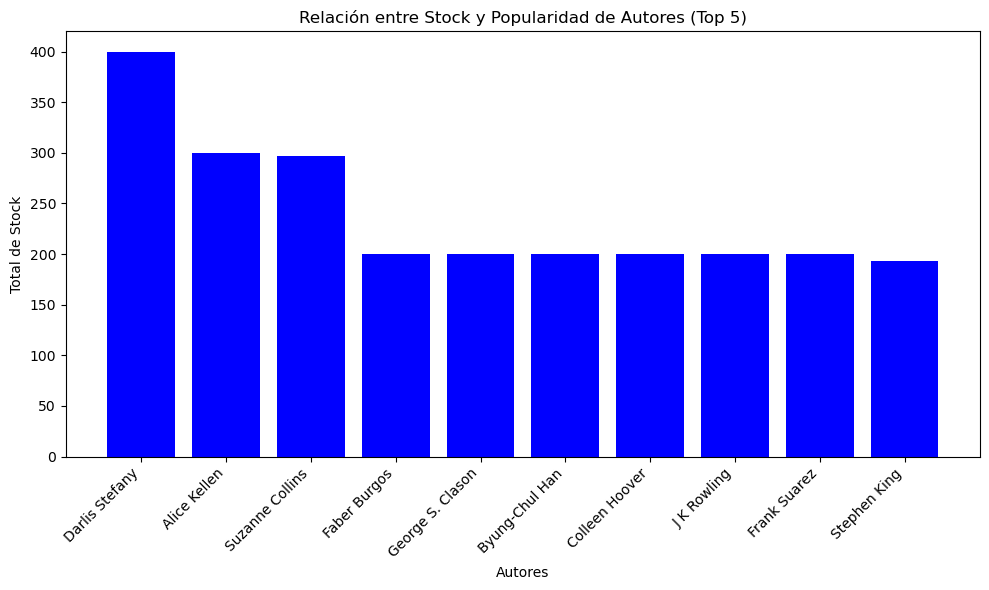

In [17]:
import psycopg2
import matplotlib.pyplot as plt

db_params = {
    'database': 'Web_scraping_busca_libre',
    'user': 'postgres',
    'password': 'Nico1029',
    'host': 'localhost',
    'port': '5432',
}

query = """
    SELECT autor, SUM(stock) AS total_stock
    FROM Libros
    GROUP BY autor
    ORDER BY total_stock DESC
    LIMIT 10;
"""

try:
    connection = psycopg2.connect(**db_params)
    cursor = connection.cursor()

    cursor.execute(query)
    results = cursor.fetchall()

    autores = [row[0] for row in results]
    total_stock = [row[1] for row in results]

    plt.figure(figsize=(10, 6))
    plt.bar(autores, total_stock, color='blue')
    plt.xlabel('Autores')
    plt.ylabel('Total de Stock')
    plt.title('Relación entre Stock y Popularidad de Autores (Top 5)')
    plt.xticks(rotation=45, ha='right')  
    plt.tight_layout()

    plt.show()

except (Exception, psycopg2.Error) as error:
    print(f"Error al obtener datos de la base de datos: {error}")

finally:
    if connection:
        cursor.close()
        connection.close()


### 7. Creamos un grafico de torta para poder mostrar la distribución de descuento por autor

C:\Users\Nico\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


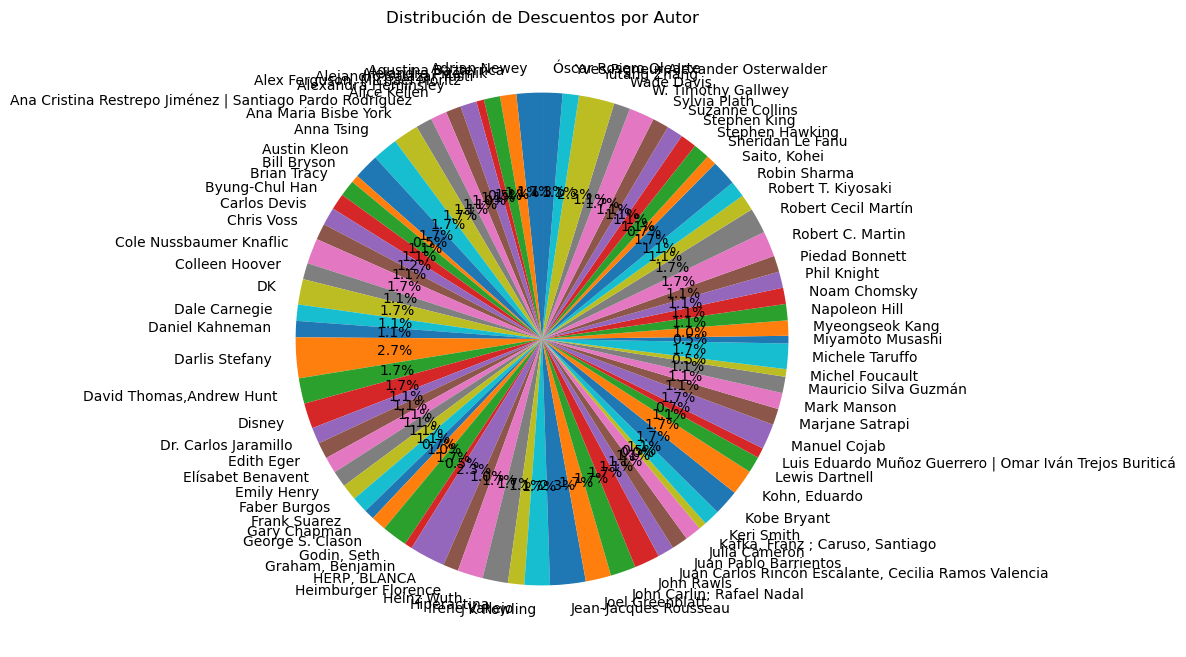

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2

connection = psycopg2.connect(database='Web_scraping_busca_libre', user='postgres', password='Nico1029', host='localhost', port='5432')

consulta_sql = "SELECT autor, descuento_porcentaje, precio_antes, precio_ahora FROM Libros;"
df = pd.read_sql_query(consulta_sql, connection)

plt.figure(figsize=(10, 8))
descuentos_por_autor = df.groupby('autor')['descuento_porcentaje'].mean()
descuentos_por_autor.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Distribución de Descuentos por Autor')
plt.ylabel('')  
plt.show()



connection.close()


### Pasa lo mismo que en el ítem 6, es casi que imposible saber cuál es cuál, por lo que de igual forma se escogerán los primeros 10 autores con los mejores descuentos promedios

C:\Users\Nico\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


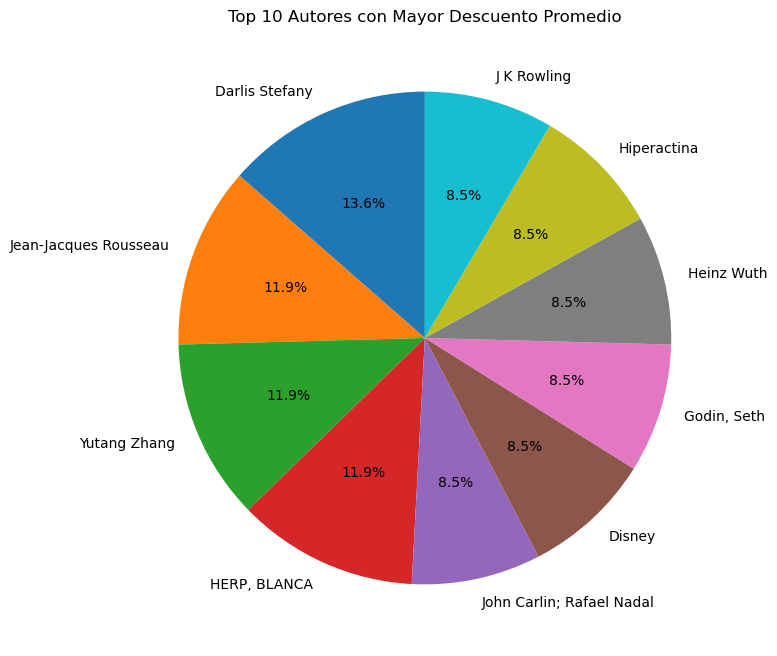

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2

connection = psycopg2.connect(database='Web_scraping_busca_libre', user='postgres', password='Nico1029', host='localhost', port='5432')

consulta_sql = "SELECT autor, descuento_porcentaje, precio_antes, precio_ahora FROM Libros;"
df = pd.read_sql_query(consulta_sql, connection)

descuentos_por_autor = df.groupby('autor')['descuento_porcentaje'].mean().sort_values(ascending=False)

top_10_autores = descuentos_por_autor.head(10)

plt.figure(figsize=(10, 8))
top_10_autores.plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Autores con Mayor Descuento Promedio')
plt.ylabel('')  
plt.show()

connection.close()


### 8. En este apartado graficamos la distribución de stock por año, los primeros valores, el 0, 1 y 14 son valores que no tienen nada que ver, ya que al momento de realizar el scrap a los libros no se pudo recolectar bien esa información por diferentes motivos, pero aún así, son muy pocos valores

C:\Users\Nico\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\Nico\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


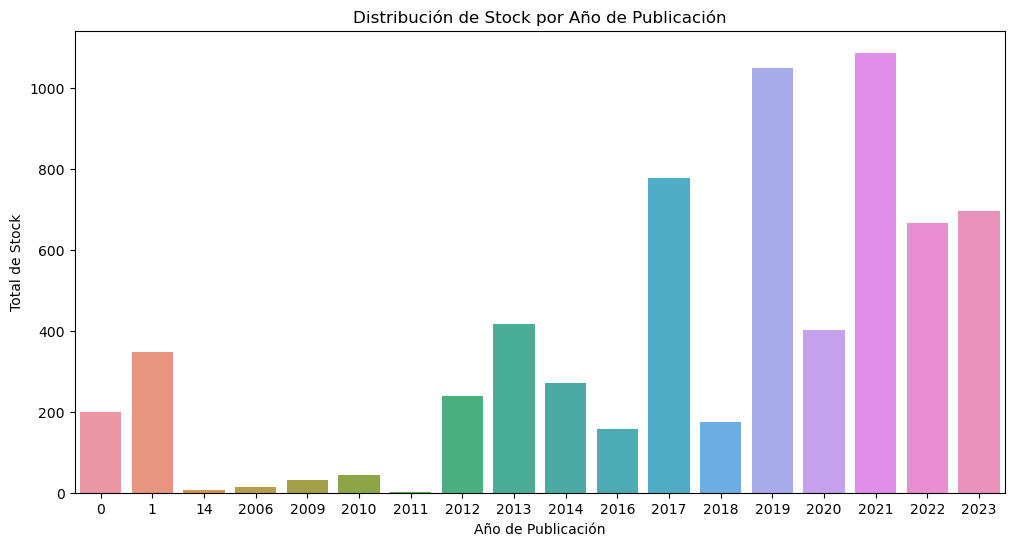

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import psycopg2

connection = psycopg2.connect(database='Web_scraping_busca_libre', user='postgres', password='Nico1029', host='localhost', port='5432')

consulta_sql_burbujas = "SELECT precio_ahora, descuento_porcentaje, stock FROM Libros;"
df_burbujas = pd.read_sql_query(consulta_sql_burbujas, connection)



consulta_sql_barras_apiladas = "SELECT anio_publicacion, SUM(stock) AS total_stock FROM Libros GROUP BY anio_publicacion ORDER BY anio_publicacion;"
df_barras_apiladas = pd.read_sql_query(consulta_sql_barras_apiladas, connection)

plt.figure(figsize=(12, 6))
sns.barplot(x='anio_publicacion', y='total_stock', data=df_barras_apiladas)
plt.title('Distribución de Stock por Año de Publicación')
plt.xlabel('Año de Publicación')
plt.ylabel('Total de Stock')
plt.show()

connection.close()


### 9. La grafica de las editoriales que distribuyen la mayoría de libros

C:\Users\Nico\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


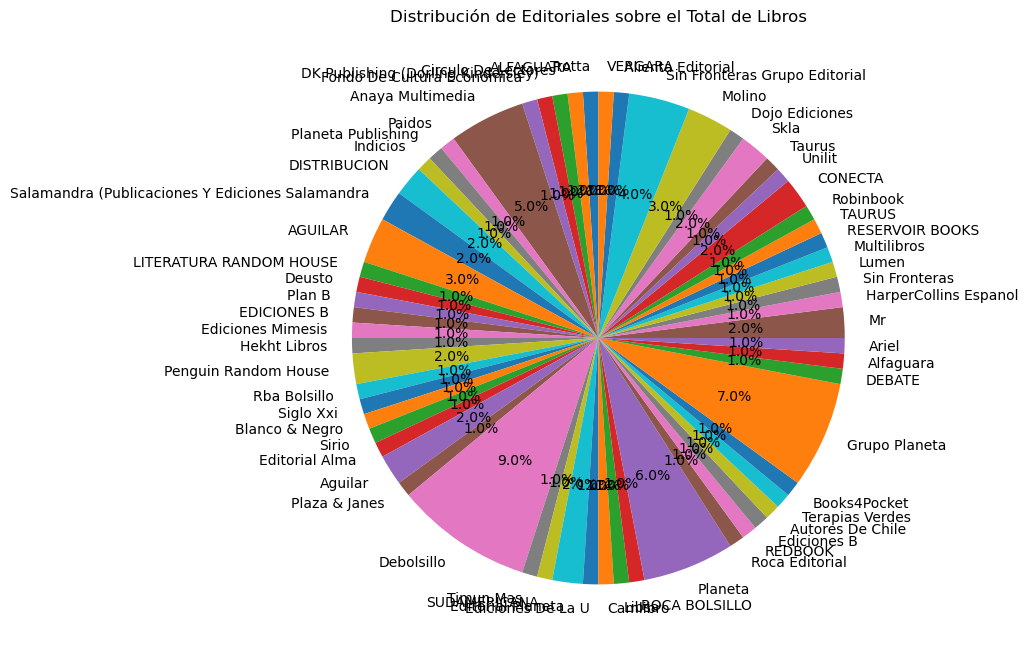

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

connection = psycopg2.connect(database='Web_scraping_busca_libre', user='postgres', password='Nico1029', host='localhost', port='5432')

consulta_editoriales = "SELECT editorial, COUNT(id) AS total_libros FROM Libros GROUP BY editorial;"
df_editoriales = pd.read_sql_query(consulta_editoriales, connection)

if not df_editoriales.empty:
    plt.figure(figsize=(10, 8))
    plt.pie(df_editoriales['total_libros'], labels=df_editoriales['editorial'], autopct='%1.1f%%', startangle=90)
    plt.title('Distribución de Editoriales sobre el Total de Libros')
    plt.show()
else:
    print("No hay datos para graficar. Revisa tus datos.")

connection.close()



### Igual que en las graficas anteriores, se limitó a las primeras 5 editoriales 

C:\Users\Nico\anaconda3\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


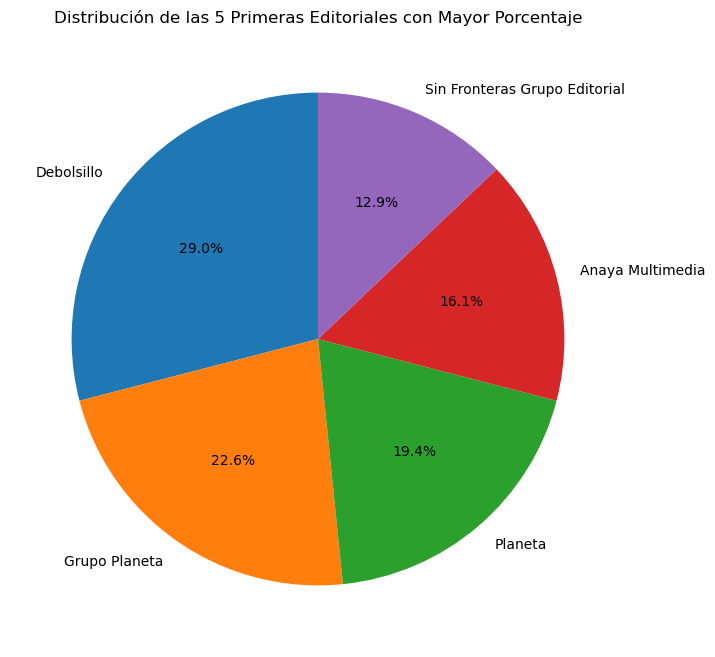

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2

connection = psycopg2.connect(database='Web_scraping_busca_libre', user='postgres', password='Nico1029', host='localhost', port='5432')

consulta_editoriales = "SELECT editorial, COUNT(id) AS total_libros FROM Libros GROUP BY editorial;"
df_editoriales = pd.read_sql_query(consulta_editoriales, connection)

df_editoriales['porcentaje'] = (df_editoriales['total_libros'] / df_editoriales['total_libros'].sum()) * 100

df_top5_editoriales = df_editoriales.sort_values(by='porcentaje', ascending=False).head(5)

if not df_top5_editoriales.empty:
    plt.figure(figsize=(10, 8))
    plt.pie(df_top5_editoriales['total_libros'], labels=df_top5_editoriales['editorial'], autopct='%1.1f%%', startangle=90)
    plt.title('Distribución de las 5 Primeras Editoriales con Mayor Porcentaje')
    plt.show()
else:
    print("No hay datos para graficar. Revisa tus datos.")

connection.close()
